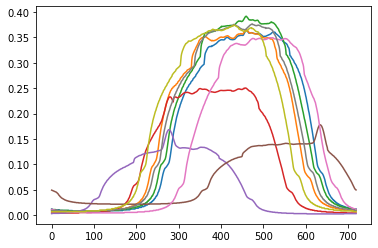

In [1]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import os
observations = []
avgs = []
for file in os.listdir():
    if 'fits' in file:
        obs = np.flip(fits.open(file)[0].data, 0)
        observations.append(obs)
        avgs.append(np.mean(obs, 0))
        plt.plot(np.mean(obs, 0))
plt.show()

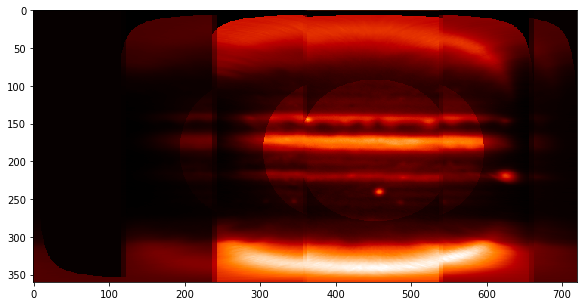

In [163]:
brightnesscutoff = 0.2
nbins = 12
binstarts = [int(x) for x in np.linspace(0, 720, nbins+1)]
lmap = np.full((360, 720), 0.)
standardBrightness = 0.5
cmaps = []

#choose the maps with the highest average brightness over the bin
for bin in range(len(binstarts)-1):
    bestObs = None
    maxBrightness = 0
    for obs in observations:
        avgBrightness = np.mean(obs[:, binstarts[bin]:binstarts[bin+1]])
        if avgBrightness > maxBrightness:
            bestObs = obs
            maxBrightness = avgBrightness
    lmap[:, binstarts[bin]:binstarts[bin+1]] = bestObs[:, binstarts[bin]:binstarts[bin+1]]
    cmaps.append(bestObs)

#stitch together at the bin edges
gradient = 6
for bin in range(len(binstarts)-2):
    stitchStart = binstarts[bin+1]-gradient//2
    stitchEnd = binstarts[bin+1]+gradient//2
    lmap[:, stitchStart:stitchEnd] = (cmaps[bin][:, stitchStart:stitchEnd] + cmaps[bin+1][:, stitchStart:stitchEnd]) / 2.0

plt.figure(figsize=(10, 5))
plt.imshow(lmap, cmap='gist_heat')
plt.show()

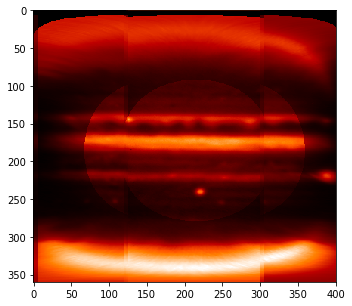

(360, 401)

In [164]:
from copy import deepcopy
#drop longitudes that fall below the brightness cutoff
lmap_lowBinsDropped = deepcopy(lmap)
cutoff = 0.15
keepLons = np.argwhere(np.mean(lmap, 0)>=cutoff).flatten()
lmap_lowBinsDropped = lmap_lowBinsDropped[:, keepLons]
plt.figure(figsize=(10, 5))
plt.imshow(lmap_lowBinsDropped, cmap='gist_heat')
plt.show()
lmap_lowBinsDropped.shape

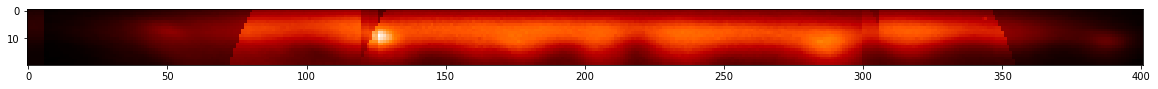

In [165]:
nebStart = 135
nebEnd = 155
neb = lmap_lowBinsDropped[nebStart:nebEnd, :]
plt.figure(figsize=(20, 15))
plt.imshow(neb, cmap='gist_heat')
plt.show()

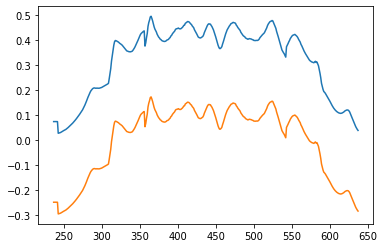

In [166]:
from scipy.signal import detrend
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.detrend.html
cutoff = 0.25
#drop bins that are entirely lower in brightness than cutoff
nebAvg = np.mean(neb, 0)
plt.plot(keepLons, nebAvg)
avg_detrended = detrend(nebAvg, type='constant', bp=binstarts) #pixels where separate cmaps meet
plt.plot(keepLons, avg_detrended)
plt.show()

In [167]:
from scipy.fft import fft
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.fft.fft.html
print('Fourier')
fourier = fft(nebAvg)
xf = np.arange(len(nebAvg)//2)
print('Non-detrended')
print(720 / len(nebAvg) * np.flip(np.argsort(fourier[0:len(nebAvg)//2]))[:10])
fourier_detrended = fft(avg_detrended)
print('Detrended')
print(720 / len(nebAvg) * np.flip(np.argsort(fourier_detrended[0:len(nebAvg)//2]))[:10])

Fourier
Non-detrended
[ 0.         17.95511222 25.13715711 12.56857855 26.93266833  8.97755611
 44.88778055  7.18204489 55.66084788 16.159601  ]
Detrended
[17.95511222 25.13715711 12.56857855 26.93266833  8.97755611 44.88778055
  7.18204489 55.66084788 16.159601   39.50124688]


In [180]:
from astropy.timeseries import LombScargle

print("Lomb-Scargle periodogram")
lon_normed = (keepLons-np.min(keepLons))/len(keepLons)
print('Non-detrended')
frequency, power = LombScargle(lon_normed,nebAvg).autopower()
print(720 / len(lon_normed) * frequency[np.flip(np.argsort(power[0:len(frequency)//20]))][:10])
print('Detrended')
frequency, power_detrended = LombScargle(lon_normed,avg_detrended).autopower()
print(720 / len(lon_normed) * frequency[np.flip(np.argsort(power_detrended[0:len(frequency)//20]))][:10])

Lomb-Scargle periodogram
Non-detrended
[0.18 0.54 0.9  1.26 1.62 1.98 2.34 4.14 3.78 4.5 ]
Detrended
[0.18 0.54 0.9  1.26 1.62 1.98 2.34 4.14 3.78 4.5 ]
